**COVID-19 Data Analysis NoteBook**
-----------------------------------


In [9]:

import sys
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import warnings as wn
wn.filterwarnings("ignore")

# Add the project root (one level above src) to sys.path
project_root = Path().resolve().parent
sys.path.append(str(project_root / "src"))
from etl.utils import load_config, get_db_connection

# Use the correct path relative to project root
config = load_config(str(project_root / "src/config/config.yaml"))
conn = get_db_connection(config)

df = pd.read_sql("SELECT * FROM covid_daily_cleaned ORDER BY date;", conn)
conn.close()

df.head()


,date,positive,negative,hospitalized_currently,death,total_test_results,positivity_rate,case_fatality_rate
0,2020-01-13,0,0,0,0,0,0.0,0.0
1,2020-01-14,0,0,0,0,0,0.0,0.0
2,2020-01-15,0,0,0,0,0,0.0,0.0
3,2020-01-16,0,0,0,0,0,0.0,0.0
4,2020-01-17,0,0,0,0,0,0.0,0.0


**Plot Positivity Rate Over Time**


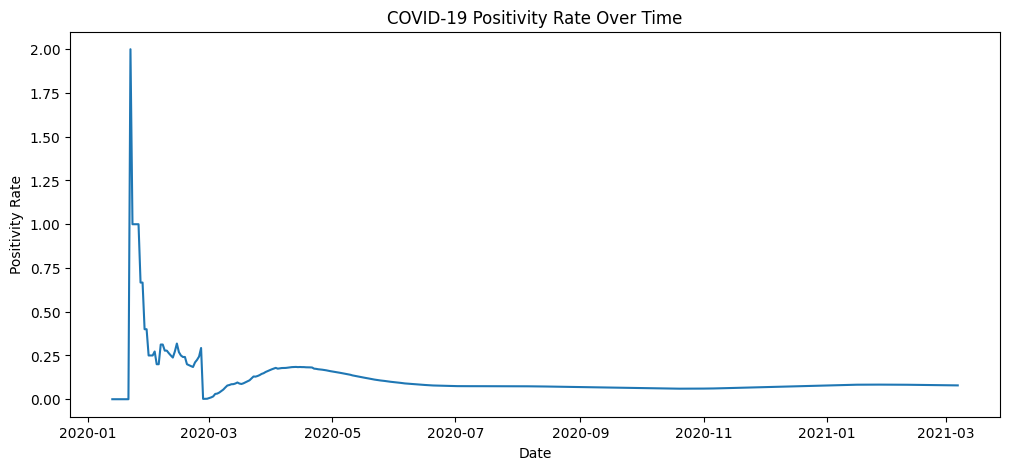

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(df['date'], df['positivity_rate'])
plt.xlabel("Date")
plt.ylabel("Positivity Rate")
plt.title("COVID-19 Positivity Rate Over Time")
plt.show()

**Plot Case Fatality Rate Over Time**

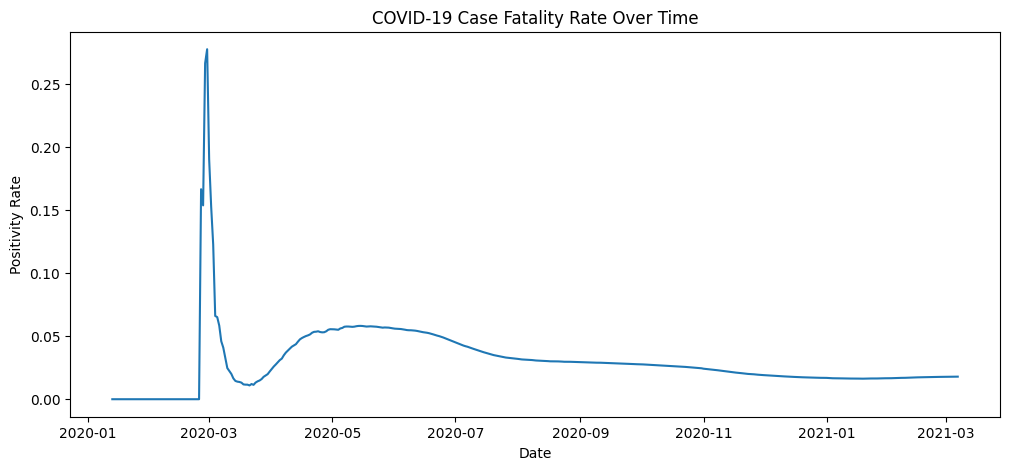

In [13]:
plt.figure(figsize=(12,5))
plt.plot(df['date'], df['case_fatality_rate'])
plt.xlabel("Date")
plt.ylabel("Positivity Rate")
plt.title("COVID-19 Case Fatality Rate Over Time")
plt.show()

**Preprocessing: Rolling averages and derived metrics**

In [14]:
# Create rolling 7-day averages for key metrics
df['positive_7d'] = df['positive'].rolling(window=7, min_periods=1).mean()
df['death_7d'] = df['death'].rolling(window=7, min_periods=1).mean()
df['hospitalized_7d'] = df['hospitalized_currently'].rolling(window=7, min_periods=1).mean()

# Handle potential infinite/NaN from divisions
df['positivity_rate'] = pd.to_numeric(df['positivity_rate'], errors='coerce')
df['case_fatality_rate'] = pd.to_numeric(df['case_fatality_rate'], errors='coerce')
df[['positivity_rate','case_fatality_rate']] = df[['positivity_rate','case_fatality_rate']].fillna(0)

df.tail()


,date,positive,negative,hospitalized_currently,death,total_test_results,positivity_rate,case_fatality_rate,positive_7d,death_7d,hospitalized_7d
415,2021-03-03,28520365,73857281,45462,508665,357888671,0.079691,0.017835,2.834251e+07,503338.428571,48370.285714
416,2021-03-04,28585852,74035238,44172,510408,359479655,0.079520,0.017855,2.840466e+07,505081.285714,47156.428571
417,2021-03-05,28654639,74307155,42541,512629,361224072,0.079326,0.017890,2.846596e+07,506835.571429,45932.000000
418,2021-03-06,28714654,74450990,41401,514309,362655064,0.079179,0.017911,2.852564e+07,508566.000000,44864.857143
419,2021-03-07,28756489,74582825,40199,515151,363825123,0.079039,0.017914,2.858354e+07,510266.571429,43843.000000


**Daily Positive Cases & 7-day average**

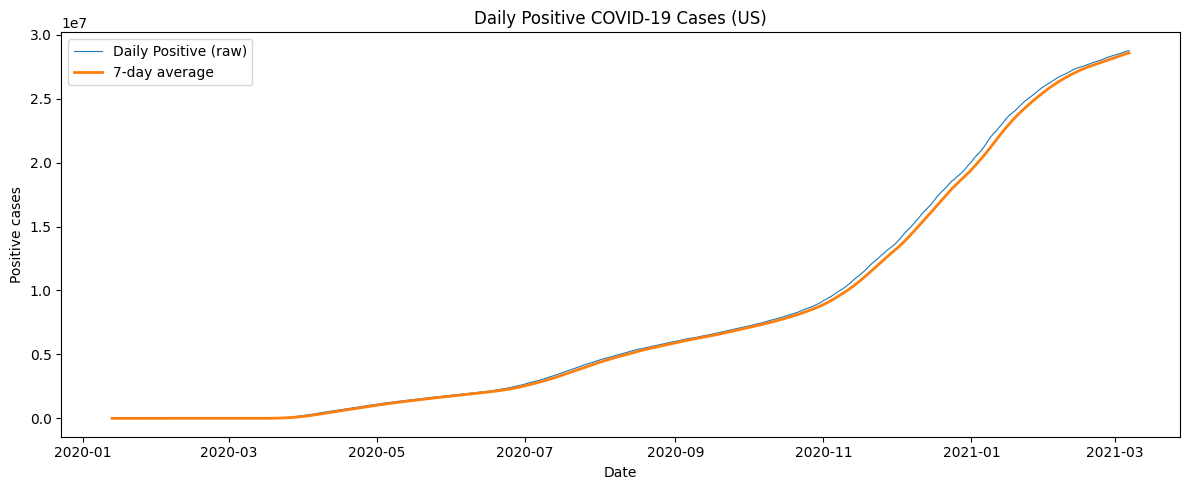

In [15]:
plt.figure(figsize=(12,5))
plt.plot(df['date'], df['positive'], label='Daily Positive (raw)', linewidth=0.8)
plt.plot(df['date'], df['positive_7d'], label='7-day average', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Positive cases')
plt.title('Daily Positive COVID-19 Cases (US)')
plt.legend()
plt.tight_layout()
plt.show()


**Hospitalizations (current) & 7-day average**

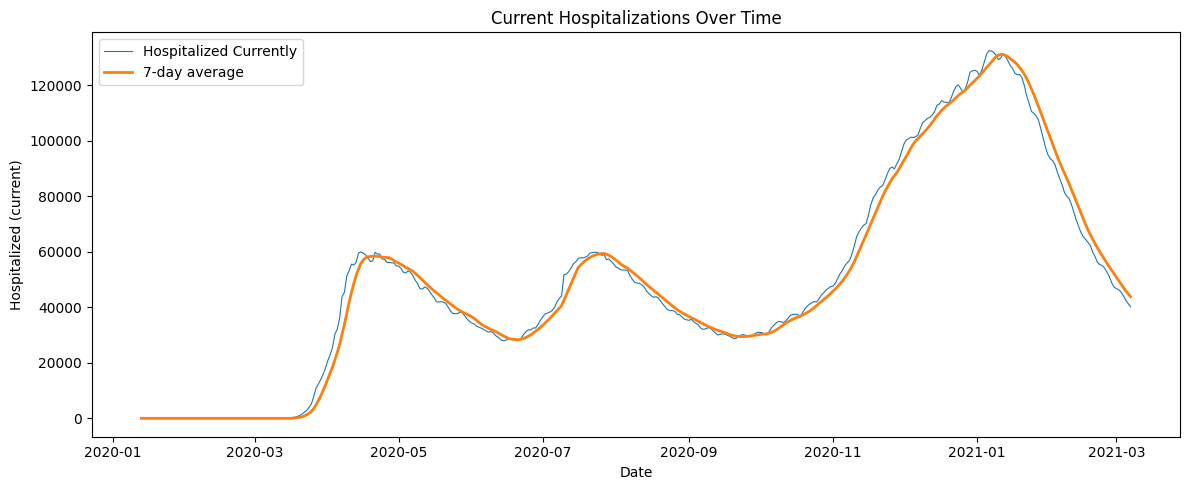

In [16]:
plt.figure(figsize=(12,5))
plt.plot(df['date'], df['hospitalized_currently'], label='Hospitalized Currently', linewidth=0.8)
plt.plot(df['date'], df['hospitalized_7d'], label='7-day average', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Hospitalized (current)')
plt.title('Current Hospitalizations Over Time')
plt.legend()
plt.tight_layout()
plt.show()


**Case Fatality Rate (CFR) and Positivity Rate**

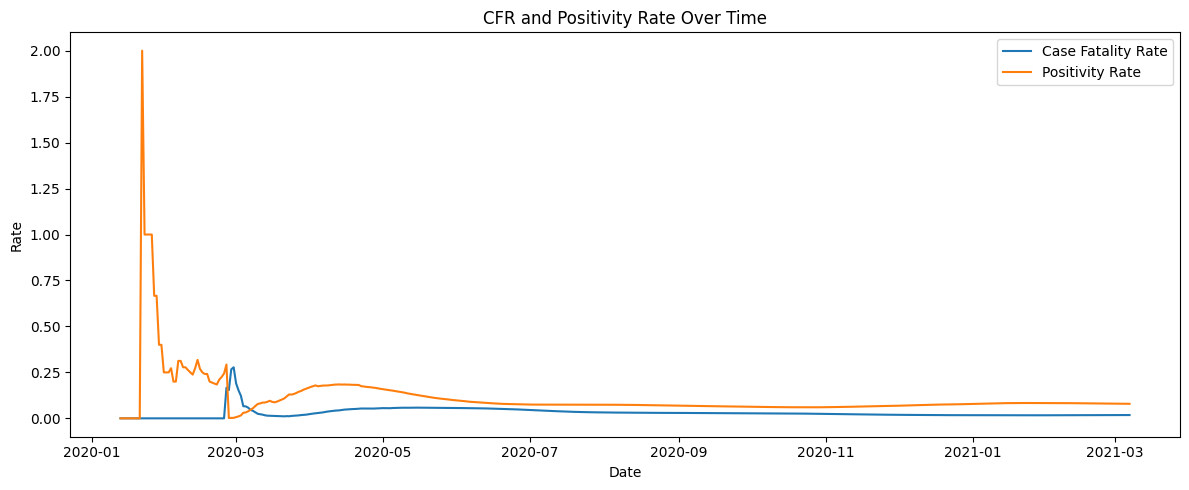

In [17]:
plt.figure(figsize=(12,5))
plt.plot(df['date'], df['case_fatality_rate'], label='Case Fatality Rate', linewidth=1.5)
plt.plot(df['date'], df['positivity_rate'], label='Positivity Rate', linewidth=1.5)
plt.xlabel('Date')
plt.ylabel('Rate')
plt.title('CFR and Positivity Rate Over Time')
plt.legend()
plt.tight_layout()
plt.show()

**Peak detection — identify top peaks in daily positive cases**

In [18]:
# Simple peak detection: local maxima compared to neighbours and sorted by value
df['is_peak'] = (df['positive'] > df['positive'].shift(1)) & (df['positive'] > df['positive'].shift(-1))

peaks = df[df['is_peak']].sort_values('positive', ascending=False).head(10)[['date','positive']]
peaks = peaks.reset_index(drop=True)
print(f"Top 10 peaks by daily positive cases: {peaks}")

Top 10 peaks by daily positive cases: Empty DataFrame
Columns: [date, positive]
Index: []
